In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm

In [2]:
sess = tf.Session()

# Loading NIH metadata

## Raw Metadata

In [3]:
path = '/mnt/storage/data/nih-chest-xrays/'
raw_data = pd.read_csv(os.path.join(path, 'Data_Entry_2017.csv'))
raw_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143


## Extract paths and labels

In [4]:
data = raw_data[['Image Index', 'Finding Labels']].copy()
data.columns = ['image', 'label']
data.image = os.path.join(path, 'images/') + data.image
data = data.sample(frac=1)
data.head()

,image,label
4907,/mnt/storage/data/nih-chest-xrays/images/00001...,No Finding
32057,/mnt/storage/data/nih-chest-xrays/images/00008...,No Finding
90233,/mnt/storage/data/nih-chest-xrays/images/00022...,Mass
56357,/mnt/storage/data/nih-chest-xrays/images/00014...,Atelectasis
101562,/mnt/storage/data/nih-chest-xrays/images/00026...,Infiltration


In [5]:
exists = data.image.map(os.path.exists)

## Produce a binary matrix of labels

In [6]:
encoded_labels = data.label.str.get_dummies(sep='|').sort_index(axis=1)
encoded_labels.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
4907,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
32057,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
90233,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
56357,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
101562,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


# Read data from Dataset

## Load individual items directly from metadata

In [7]:
dataset = tf.data.Dataset.from_tensor_slices({
    'index': data.index,
    'path': data['image'].values,
    'label': encoded_labels.values.astype(np.float32)
})

In [8]:
iterator = dataset.make_one_shot_iterator()
item = iterator.get_next()
sess.run(item)

{'index': 4907,
 'label': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       dtype=float32),
 'path': b'/mnt/storage/data/nih-chest-xrays/images/00001309_000.png'}

## Read and decode the corresponding image files

In [9]:
def read_file(item):
    #item['path'] = tf.Print(item['path'], [item['path']], 'path: ')
    item['image'] = tf.read_file(item['path'])
    return item

def decode_image(item):
    decoded = tf.image.decode_image(item['image'])
    item['image'] = tf.image.convert_image_dtype(decoded, tf.float32)
    # All images are B&W, but some seem to have the channel replicated,
    # to avoid issues we simply select the first channel
    item['image'] = tf.expand_dims(item['image'][:, :, 0], axis=-1)
    item['image'].set_shape([None, None, 1])
    return item

dataset = dataset.map(
    lambda item: decode_image(read_file(item)), num_parallel_calls=32)

iterator = dataset.make_one_shot_iterator()
item = iterator.get_next()

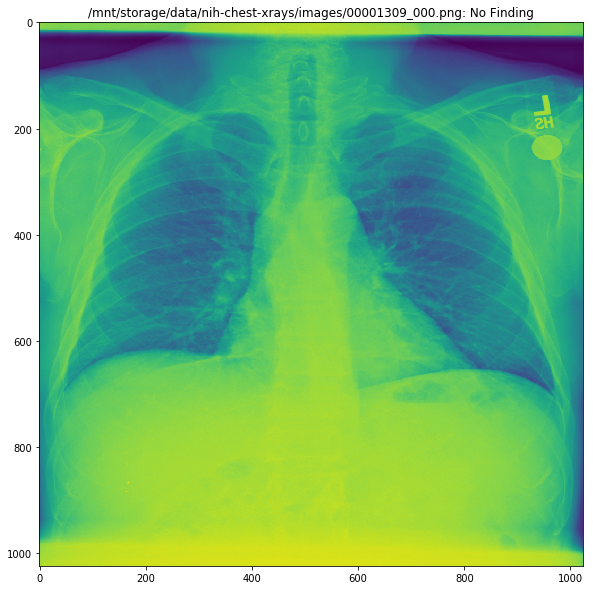

In [10]:
sample = sess.run(item)

plt.figure(figsize=(10, 10))
plt.imshow(sample['image'][..., 0])
plt.title(sample['path'].decode() + ': '+ data.label[sample['index']])
plt.show()

## How quickly can we run through the data?

In [ ]:
batch_size = 12

dataset = dataset.shuffle(100)
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()  # repeat indefinitely (reshuffled each time)

iterator = dataset.make_one_shot_iterator()
batch = iterator.get_next()

In [ ]:
for _ in tqdm.trange(len(data) // batch_size, unit='batch', smoothing=1):
    sess.run(batch)

 11%|█         | 1039/9343 [00:43<05:45, 24.06batch/s]